# Learning Rates (Updated Notebook)

## Setup 

In [4]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from tqdm import tqdm
from openTSNE import TSNE
import time
import json
from math import ceil

# for local imports  
from pathlib import Path
import sys
import os 

script_dir = Path.cwd().parent / "scripts"
sys.path.append(str(script_dir))

figures_dir = Path.cwd().parent / "figures"
sys.path.append(str(figures_dir))

results_dir = Path.cwd().parent / "results"
sys.path.append(str(results_dir))

import datasets
import quality_measures

## Functions 

### KLD Monitor

In [5]:
from openTSNE import callbacks

class KLDMonitor(callbacks.Callback):
    def __init__(self, record_every=5):
        self.record_every = record_every
        self.kl_divergences = {}
    
    def __call__(self, iteration, error, embedding):
        """
        Monitors KL divergence while ensuring unique iteration values.
        """
        # Only check every `record_every` iterations
        if iteration % self.record_every == 0:
            # in this case we are in the embedding phase  
            if iteration in self.kl_divergences or iteration > 250:
                self.kl_divergences[iteration + 250] = error 
            # in the EE phase     
            else: 
                self.kl_divergences[iteration] = error

### Running t-SNE

In [6]:
def run_tsne_with_callbacks_and_timing(datasets, learning_rates, verbose=False, filename="eta_times.json"):
    """Returns embedding dictionary with keys given by perplexity and dataset used to generate the embedding.
    
    Also tracks and saves the time taken for each embedding run to a JSON file.
    
    Parameters:
    - datasets: list of tuples (data, labels)
    - learning rates: list of learning rates for t-SNE
    - verbose (bool): If True, prints additional TSNE information.
    - save_times_path (str): File path to automatically save the time tracking data.
    
    Returns:
    - embedding_dict: dictionary with keys (perp, dataset_index) mapping to (embedding, labels, kld_values)
    """
    embedding_dict = {}
    timings = []  # List to store timing information for each embedding

    save_times_path = os.path.join(results_dir, filename)

    for eta in tqdm(learning_rates):
        for i, dataset in enumerate(datasets):
            data, labels = dataset
            # Convert to np.array if data is a DataFrame
            if hasattr(data, "values"):
                data = data.values.astype(float)

            kld_monitor = KLDMonitor()
            
            tsne = TSNE(learning_rate=eta, n_jobs=-1,
                        callbacks=kld_monitor, callbacks_every_iters=5,
                        random_state=42, verbose=verbose)
            
            start_time = time.time()
            embedding = tsne.fit(data)
            elapsed_time = time.time() - start_time
            
            kld_values = kld_monitor.kl_divergences
            embedding_dict[(eta, i)] = (embedding, labels, kld_values)
            
            # Record timing data for this embedding
            timings.append({
                "learning_rate": eta,
                "dataset_index": i,
                "time_taken_seconds": elapsed_time
            })

    # Automatically save the timing information to the specified JSON file.
    with open(save_times_path, "w") as f:
        json.dump(timings, f, indent=4)
    
    return embedding_dict


### Embedding Grid Plotting

In [12]:
def plot_embedding_grid(embeddings, row_parameter, column_parameter, row_string="", column_string="", cmap="tab20", file_start="eta"):
    """
    Plots a grid of t-SNE embeddings with a common column label.

    Parameters:
    - embeddings (dict): Keys are (col_value, row_value) tuples, and values are (embedding_array, labels, kld_values).
    - row_parameter (list): Values for rows (e.g., datasets [0, 1, 2, 3]).
    - column_parameter (list): Values for columns (e.g., number of iterations, perplexity, etc.).
    - row_string (str): Label for the row axis.
    - column_string (str): Common label for the column axis (displayed once over the grid).
    - cmap: "tab20" by default 
    - file_start: e.g. "eta"
    """
    num_rows = len(row_parameter)
    num_cols = len(column_parameter)
    
    subplot_size = 3  
    fig, axes = plt.subplots(num_rows, num_cols, 
                             figsize=(12, subplot_size * num_rows), # (num_cols * subplot_size, num_rows * subplot_size), 
                             squeeze=False)
    
    # Add a common column label above the grid 
    fig.suptitle(column_string, fontsize=12)

    # Plot embeddings in each subplot
    for row_idx, row_value in enumerate(row_parameter):
        for col_idx, col_value in enumerate(column_parameter):
            ax = axes[row_idx, col_idx]
            
            # Unpack; kld_values is ignored here.
            embedding, labels, _ = embeddings[(col_value, row_value)]

            # plot scatterplot 
            ax.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap=cmap, s=7 if row_idx==0 else 2, alpha=1.0 if row_idx==0 else 0.6)
            ax.set_xticks([])
            ax.set_yticks([])
            
            # Remove axis outlines
            for spine in ax.spines.values():
                spine.set_visible(False)
            
            # For the top row, display just the column value as the individual title
            if row_idx == 0:
                ax.set_title(f"{col_value}", fontsize=12, pad=10)
            
            # Optionally, add row labels on the left-most column
            if col_idx == 0 and row_string:
                ax.set_ylabel(f"{row_string}: {row_value}", fontsize=12, labelpad=10)
    
    # Adjust layout to make room for the common column label
    plt.subplots_adjust(wspace=0.2, hspace=0.2, top=0.93)

    # Save the figure to the specific folder
    save_path = os.path.join(figures_dir, f"{file_start}_embedding_grid_{cmap}.png")
    plt.savefig(save_path, bbox_inches="tight")

    plt.show()


### Plot Quality Measures (without KLD)

In [13]:
def plot_quality_measures(quality_results, dataset_names, plot_name="perp", x_axis_label="Learning Rate", x_axis_entries=None):
    """
    Plots three side-by-side plots for the three embedding quality measures.

    Parameters:
        quality_results (dict): Maps x-axis entries to dataset indices with tuples (mnn, mnn_global, rho).
        dataset_names (dict): Maps dataset indices to dataset names.
        plot_name (str): For saving the file, e.g. "perp", "n_iter" etc.
        x_axis_label (str): Label for the x-axis.
        x_axis_entries (list): Custom x-axis entries; defaults to sorted keys of quality_results (this should be okay).
    """
    if x_axis_entries is None:
        x_axis_entries = list(quality_results.keys())

    dataset_indices = sorted(next(iter(quality_results.values())).keys())  # Extract dataset indices
    dataset_data = {d: {'mnn': [], 'mnn_global': [], 'rho': []} for d in dataset_indices}

    # Extract data
    for x in x_axis_entries:
        for d in dataset_indices:
            mnn, mnn_global, rho = quality_results[x][d]
            dataset_data[d]['mnn'].append(mnn)
            dataset_data[d]['mnn_global'].append(mnn_global)
            dataset_data[d]['rho'].append(rho)

    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    titles = ["KNN", "KNC", "CPD"]

    for i, (metric, title) in enumerate(zip(['mnn', 'mnn_global', 'rho'], titles)):
        for d, data in dataset_data.items():
            axes[i].plot(x_axis_entries, data[metric], marker='o', linestyle='-', label=dataset_names.get(d, f"{d}"))
        axes[i].set_title(title, fontsize=12)
        axes[i].set_xlabel(x_axis_label, fontsize=12)

    # Formatting
    for ax in axes:
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.tick_params(axis="both", which="major", labelsize=10, width=0.5)
        ax.tick_params(axis="both", which="minor", labelsize=8, width=0.3)
        ax.spines["bottom"].set_linewidth(0.5)
        ax.spines["left"].set_linewidth(0.5)

    axes[0].legend()  # Only first plot has legend
    plt.tight_layout()

    # Save & Show
    save_path = os.path.join(figures_dir, f"{plot_name}_3_quality_measures.png")
    plt.savefig(save_path, bbox_inches="tight")
    plt.show()


### Plot KL Divergences 2x2 grid

In [30]:
def plot_kl_divergences_grid(embedding_dict, file_start):
    """
    Plots averaged KL divergence curves (in this case, single-run curves) for each learning rate,
    separately for each dataset in a 2x2 grid.

    For each dataset:
      - Extracts the KL divergence records (a dict mapping iteration -> error) for each learning rate.
      - Sorts the learning rates (numeric ones first, then any non-numeric).
      - Plots the KL divergence curve for each learning rate with the legend label using the Greek letter η.
    
    Parameters:
      embedding_dict (dict): Dictionary with keys (η, dataset_index) mapping to 
                             (embedding, labels, kld_values) where kld_values is a dict mapping iteration -> error.
      file_start (str): e.g eta, ee etc.
    """

    # Determine unique dataset indices.
    datasets = sorted({ds for (_, ds) in embedding_dict.keys()})
    
    # Optional: map dataset indices to names.
    dataset_names = {0: "Iris", 1: "Macosko", 2: "MNIST", 3: "Flow18"}
    
    # Create a 2x2 grid of subplots.
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    
    # Loop over each dataset to plot its KL divergence curves.
    for idx, dataset in enumerate(datasets):
        ax = axes[idx]
        
        # Collect learning rates for this dataset.
        lrs = [eta for (eta, ds) in embedding_dict.keys() if ds == dataset]
        # Order learning rates: numeric first (sorted), then any non-numeric - this isn't strictly necessary
        #numeric_lrs = sorted([eta for eta in lrs if isinstance(eta, (int, float))])
        #non_numeric_lrs = [eta for eta in lrs if not isinstance(eta, (int, float))]
        #ordered_lrs = numeric_lrs + non_numeric_lrs
        
        # Plot each learning rate's KL divergence curve.
        for eta in lrs:
            _, _, kld_values = embedding_dict[(eta, dataset)]
            # Sort iterations and get corresponding error values.
            iterations = sorted(kld_values.keys())
            errors = [kld_values[it] for it in iterations]
            ax.plot(iterations, errors, linestyle='-', label=f"η = {eta}")
        
        # Format the subplot.
        ax.set_xlabel("Iteration", fontsize=12)
        ax.set_ylabel("KL Divergence", fontsize=12)
        title = dataset_names.get(dataset, str(dataset))
        ax.set_title(title, fontsize=12)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.tick_params(axis="both", which="major", labelsize=10, width=0.5)
        ax.tick_params(axis="both", which="minor", labelsize=8, width=0.3)
        
        if idx==0: 
          ax.legend(fontsize=12)
    
    # Hide any unused subplots (if fewer than 4 datasets).
    for j in range(len(datasets), len(axes)):
        axes[j].axis("off")
    
    # Adjust spacing between subplots.
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    
    # Save and display the figure.
    save_path = os.path.join(figures_dir, f"{file_start}_kl_divergences_grid.png")
    plt.savefig(save_path, bbox_inches="tight")
    plt.show()


## Experiments

In [15]:
all_data = datasets.load_all_datasets()

In [ ]:
# for testing a smaller number of datapoints 
n_points = 2000
all_data = [datasets.load_n_samples(n_points, X, y) for (X, y) in all_data]

In [20]:
learning_rates = [1, 200, 800, "auto"]

In [21]:
embeddings_dict = run_tsne_with_callbacks_and_timing(all_data, learning_rates, verbose=False)

100%|██████████| 4/4 [00:29<00:00,  7.32s/it]


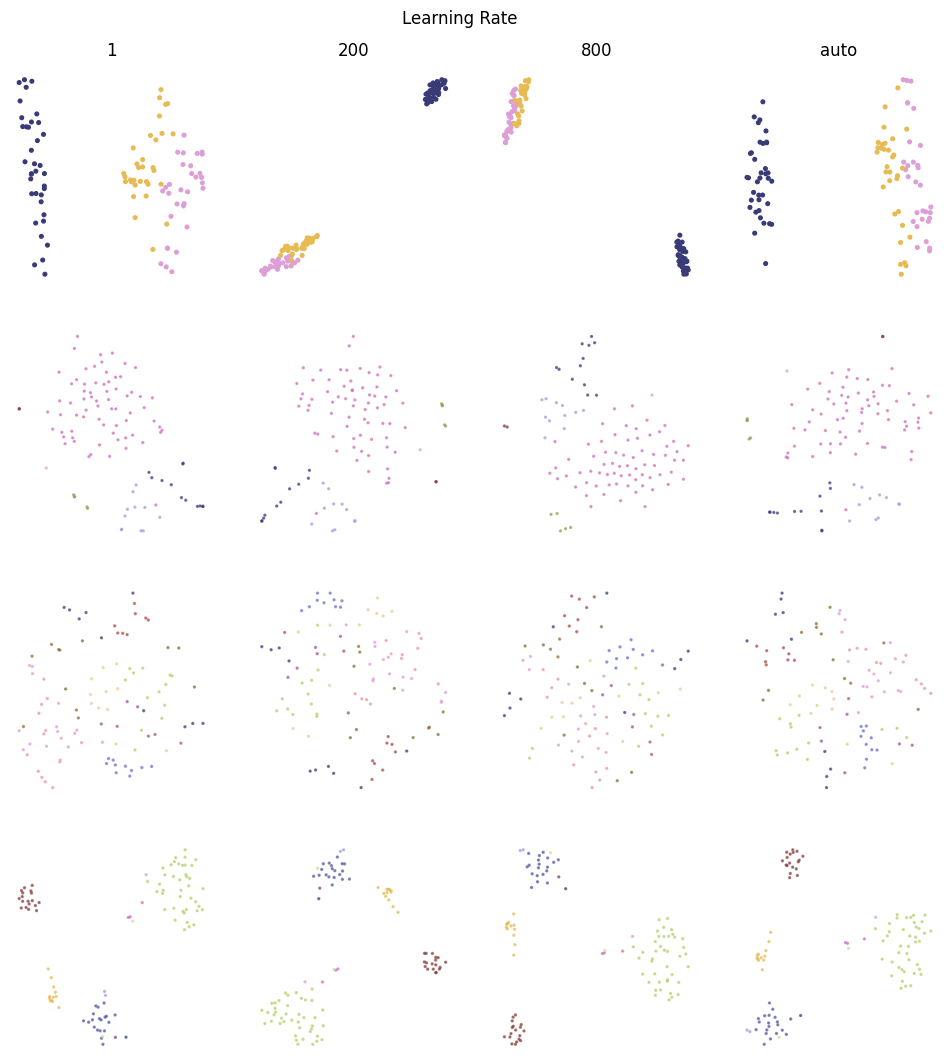

In [22]:
plot_embedding_grid(embeddings_dict, row_parameter=[0,1,2,3], column_parameter=learning_rates, row_string="", column_string="Learning Rate", cmap="tab20b", file_start="eta")

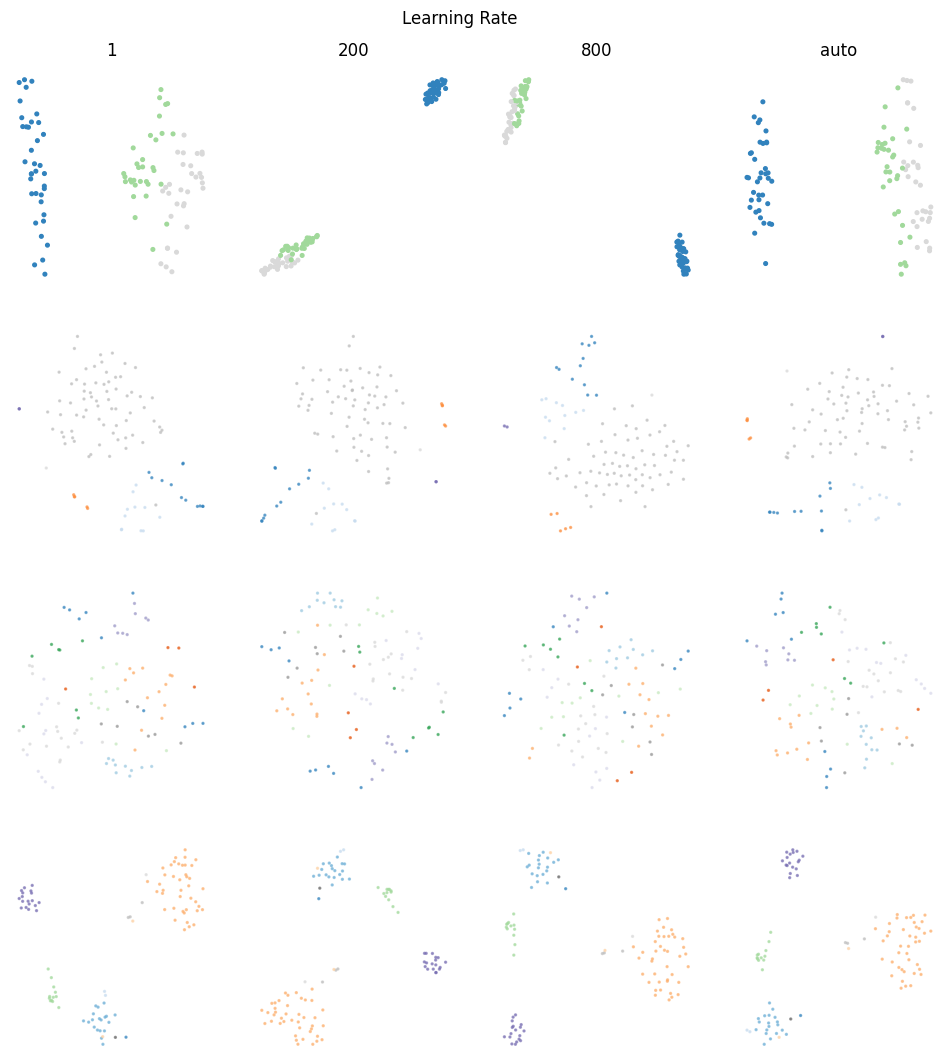

In [23]:
plot_embedding_grid(embeddings_dict, row_parameter=[0,1,2,3], column_parameter=learning_rates, row_string="", column_string="Learning Rate", cmap="tab20c", file_start="eta")

### Measuring Quality

In [24]:
quality_results = quality_measures.compute_quality_results(embeddings_dict, all_data)

In [25]:
dataset_names = {0: "Iris", 1: "Macosko", 2: "MNIST", 3: "Flow"}

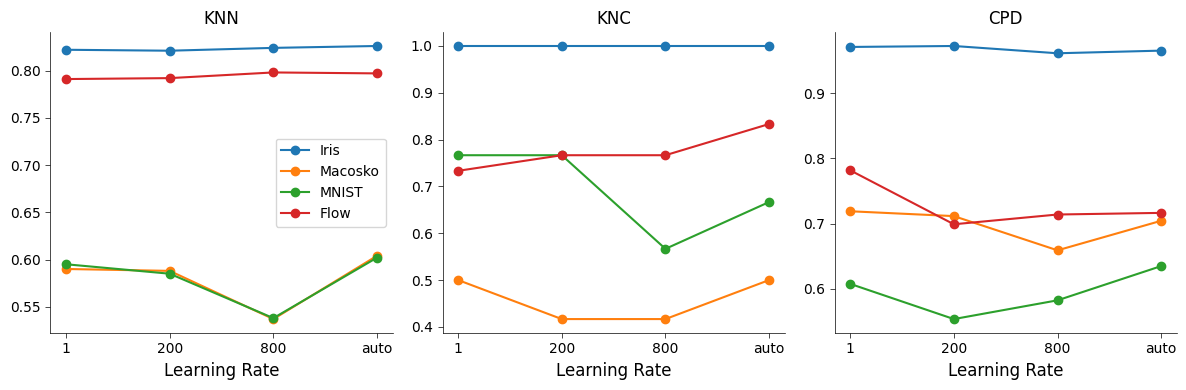

In [26]:
plot_quality_measures(quality_results, dataset_names, "eta", x_axis_label="Learning Rate")

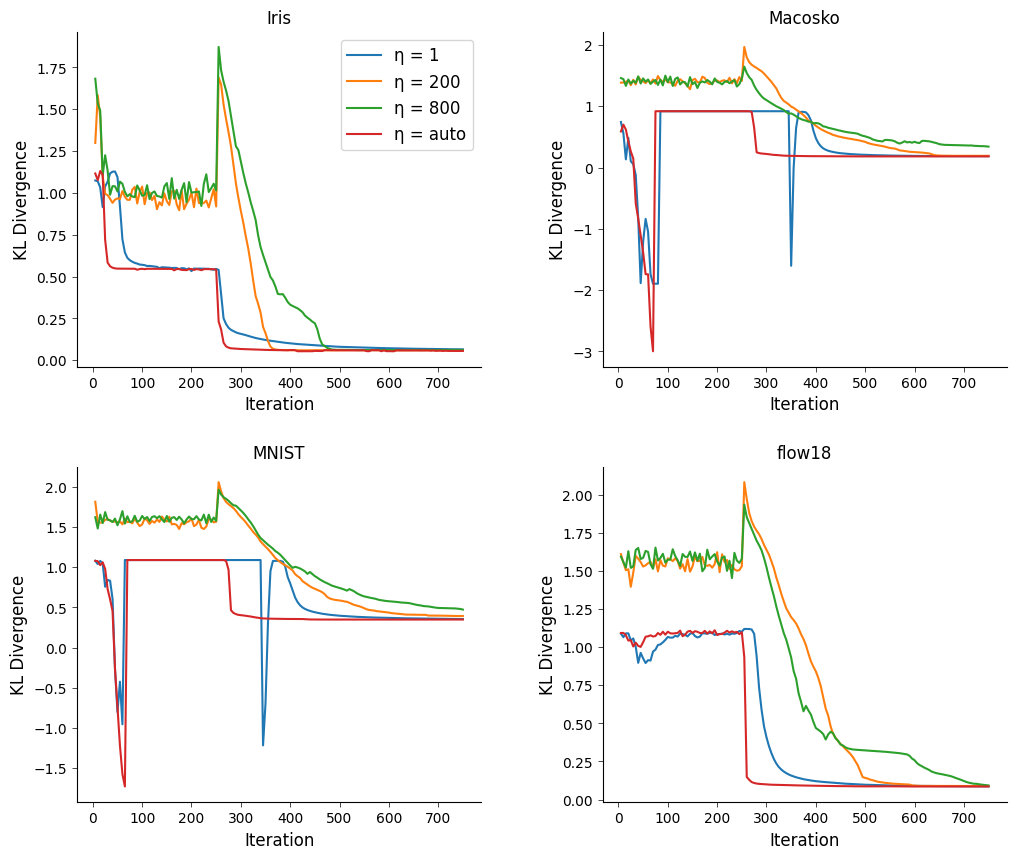

In [29]:
plot_kl_divergences_grid(embeddings_dict, "eta")